In [58]:
import pandas as pd
import paths
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import ceil

In [59]:
# labels preprocessing
df_labels = pd.read_csv(paths.labels_path)
df_labels = df_labels.rename(columns={'Participant': 'InterviewID'})
df_labels = df_labels.drop(columns=['Worker'])
df_labels = df_labels.groupby('InterviewID').mean().reset_index()
df_labels['InterviewID'] = df_labels['InterviewID'].str.upper()
# drop EyeContact column for now
df_labels = df_labels.drop(columns=['EyeContact'])

In [60]:
df_lexical = pd.read_csv(paths.pp_lexical_path)
df_prosodical = pd.read_csv(paths.pp_prosodical_path)
df_smile = pd.read_csv(paths.pp_smile_path)
df = df_lexical.merge(df_prosodical, on='InterviewID').merge(df_smile, on='InterviewID').merge(df_labels, on='InterviewID')

In [94]:
df[df['InterviewID'] == 'P3']

,InterviewID,Filler_Words,Tentative_Language,Cognitive,Work,posEmotion,duration,energy,power,min_pitch,...,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
16,P3,2.742133,0.784733,1.253996,0.374059,0.177015,1.283557,0.003897,-0.034215,-0.761096,...,1.396238,-1.663093,0.8456,-1.46249,-1.43006,0.243761,-0.439592,-0.067953,-0.080921,91.372523


In [62]:
df_labels.columns

Index(['InterviewID', 'Overall', 'RecommendHiring', 'Colleague', 'Engaged',
       'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused',
       'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused',
       'Authentic', 'NotAwkward', 'Total'],
      dtype='object')

### Standardization

In [63]:
scaler = StandardScaler()
df.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])

In [64]:
df.head()

,InterviewID,Filler_Words,Tentative_Language,Cognitive,Work,posEmotion,duration,energy,power,min_pitch,...,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,P1,-0.310403,-0.348485,-1.041116,-0.527041,-0.755355,-0.934303,-0.078936,-0.033955,0.752285,...,-0.236227,0.209124,0.292724,0.287069,-0.471845,-0.480859,0.372554,-0.420058,0.364939,92.213120
1,P10,2.441884,-0.136007,0.335951,1.275159,0.363489,0.808084,0.012308,-0.013061,0.093603,...,0.440768,0.378380,0.158498,-1.657644,-2.087626,-1.837479,-0.492900,-0.115856,-1.182820,84.331549
2,P11,-0.110237,-0.702615,0.221196,1.017702,-0.568881,-0.278988,-0.097927,-0.092395,-0.144052,...,-1.443114,0.420916,-0.487213,0.129759,-0.687479,-0.756648,0.159383,-0.342821,-0.642493,84.621319
3,P12,-0.510569,-0.490137,-0.352582,-0.012127,0.177015,-0.864770,-0.094452,-0.071501,-0.123783,...,1.256068,-0.288497,0.626519,-0.526800,0.319507,0.594667,-0.077562,0.678386,-0.228354,98.584364
4,P13,-0.060195,-0.206833,-0.582094,-0.398312,-0.941829,-0.254036,-0.122734,-0.123154,0.164733,...,-1.608514,0.634504,-2.250776,0.144597,0.199953,-0.309368,0.167225,-0.589071,-1.457139,81.102279


### Random Forest Regression

In [65]:
# X with PCA
# X = df[['Filler_Words', 'Tentative_Language', 'Cognitive', 'Work', 'posEmotion', 'Prosody_PC1', 'Prosody_PC2', 'Prosody_PC3', 'Prosody_PC4', 'Prosody_PC5', 'Prosody_PC6', 'Prosody_PC7', 'Prosody_PC8', 'Prosody_PC9', 'Prosody_PC10', 'Prosody_PC11', 'Prosody_PC12', 'Prosody_PC13', 'Prosody_PC14', 'Smile Intensity', 'Head Nod', 'Head Shake']]

# X with all features
X = df[['Filler_Words', 'Tentative_Language', 'Cognitive','Work', 'posEmotion', 'duration', 'energy', 'power', 'min_pitch', 'max_pitch', 'mean_pitch', 'pitch_sd', 'pitch_abs', 'pitch_quant', 'pitchUvsVRatio', 'Time:8', 'iDifference', 'diffPitchMaxMin', 'diffPitchMaxMean', 'diffPitchMaxMode', 'intensityMin', 'intensityMax', 'intensityMean', 'intensitySD', 'intensityQuant', 'diffIntMaxMin', 'diffIntMaxMean', 'diffIntMaxMode', 'avgVal1', 'avgVal2', 'avgVal3', 'avgBand1', 'avgBand2', 'avgBand3', 'fmean1', 'fmean2', 'fmean3', 'f2meanf1', 'f3meanf1', 'f1STD', 'f2STD', 'f3STD', 'f2STDf1', 'f2STDf2', 'jitter', 'shimmer', 'jitterRap', 'meanPeriod', 'percentUnvoiced', 'numVoiceBreaks', 'PercentBreaks', 'speakRate', 'numPause', 'maxDurPause', 'avgDurPause', 'TotDurPause:3', 'iInterval', 'MaxRising:3', 'MaxFalling:3', 'AvgTotRis:3', 'AvgTotFall:3', 'numRising', 'numFall', 'Smile Intensity', 'Head Nod', 'Head Shake']]
# add EyeContact label back when doing video analysis
y = df[['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
multi_output_regressor = MultiOutputRegressor(rf_regressor)
multi_output_regressor.fit(X_train, y_train)
y_pred = multi_output_regressor.predict(X_test)


In [132]:
print(len(X_train),len(y_train),len(X_test),len(y_test))

110 110 28 28


In [66]:
for i, target in enumerate(y_test.columns):
    mse = mean_squared_error(y_test[target], y_pred[:, i])
    print(f"Target: {target}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-Squared: {r2_score(y_test[target], y_pred[:, i])}")
    print()

Target: Overall
Mean Squared Error: 0.7500317666807087
R-Squared: 0.23999285846404517

Target: RecommendHiring
Mean Squared Error: 0.6637012697841419
R-Squared: 0.2591222136619875

Target: Colleague
Mean Squared Error: 0.8275992424993672
R-Squared: 0.059993068639602076

Target: Engaged
Mean Squared Error: 0.5512078227816123
R-Squared: 0.31361676679516215

Target: Excited
Mean Squared Error: 0.515711119642277
R-Squared: 0.5507191856717051

Target: Smiled
Mean Squared Error: 0.6184666738593163
R-Squared: -0.016280213067144

Target: SpeakingRate
Mean Squared Error: 0.8954691242716315
R-Squared: 0.04727865198961212

Target: NoFillers
Mean Squared Error: 0.3935427977117731
R-Squared: 0.11723940167454605

Target: Friendly
Mean Squared Error: 0.7847694448597603
R-Squared: 0.23501089710673173

Target: Paused
Mean Squared Error: 0.7258123284095456
R-Squared: 0.402351056494199

Target: EngagingTone
Mean Squared Error: 0.6096981920242411
R-Squared: 0.5150833265142221

Target: StructuredAnswers
Me

In [67]:
# Get the base estimator (RandomForestRegressor)
base_estimator = multi_output_regressor.estimators_

# Iterate through target variables and print the top 20 features and their importances
for i, target in enumerate(y.columns):
    # Get feature importances for the i-th target
    importances = base_estimator[i].feature_importances_
    indices = importances.argsort()[::-1]

    print(f"Top 20 features for target variable: {target}")
    for f in range(20):
        print(f"{X.columns[indices[f]]}: {importances[indices[f]]}")
    print()

Top 20 features for target variable: Overall
avgBand1: 0.2951763535975196
Filler_Words: 0.054867547063985854
Smile Intensity: 0.04107482303463358
intensityQuant: 0.03524052910395593
diffIntMaxMean: 0.024823335786052992
avgVal1: 0.02327716045347592
Tentative_Language: 0.02271711873064373
numFall: 0.02069704647940171
diffIntMaxMode: 0.020239985961851982
f3meanf1: 0.020144365204973556
maxDurPause: 0.01809733503875264
f2STDf1: 0.018055768239683734
PercentBreaks: 0.01627682317631888
pitchUvsVRatio: 0.016003297939530547
Head Shake: 0.015895260672095665
intensityMin: 0.01507331736943061
jitterRap: 0.014838623848327941
f1STD: 0.014063129081626498
diffPitchMaxMode: 0.01230581611916557
shimmer: 0.012212577901783019

Top 20 features for target variable: RecommendHiring
avgBand1: 0.2613330974912774
intensityQuant: 0.05107602781407444
f3meanf1: 0.038236023860367514
jitterRap: 0.03553346818382111
avgBand3: 0.03266218816224169
Smile Intensity: 0.031774212981176615
Filler_Words: 0.02990628982851258
f1

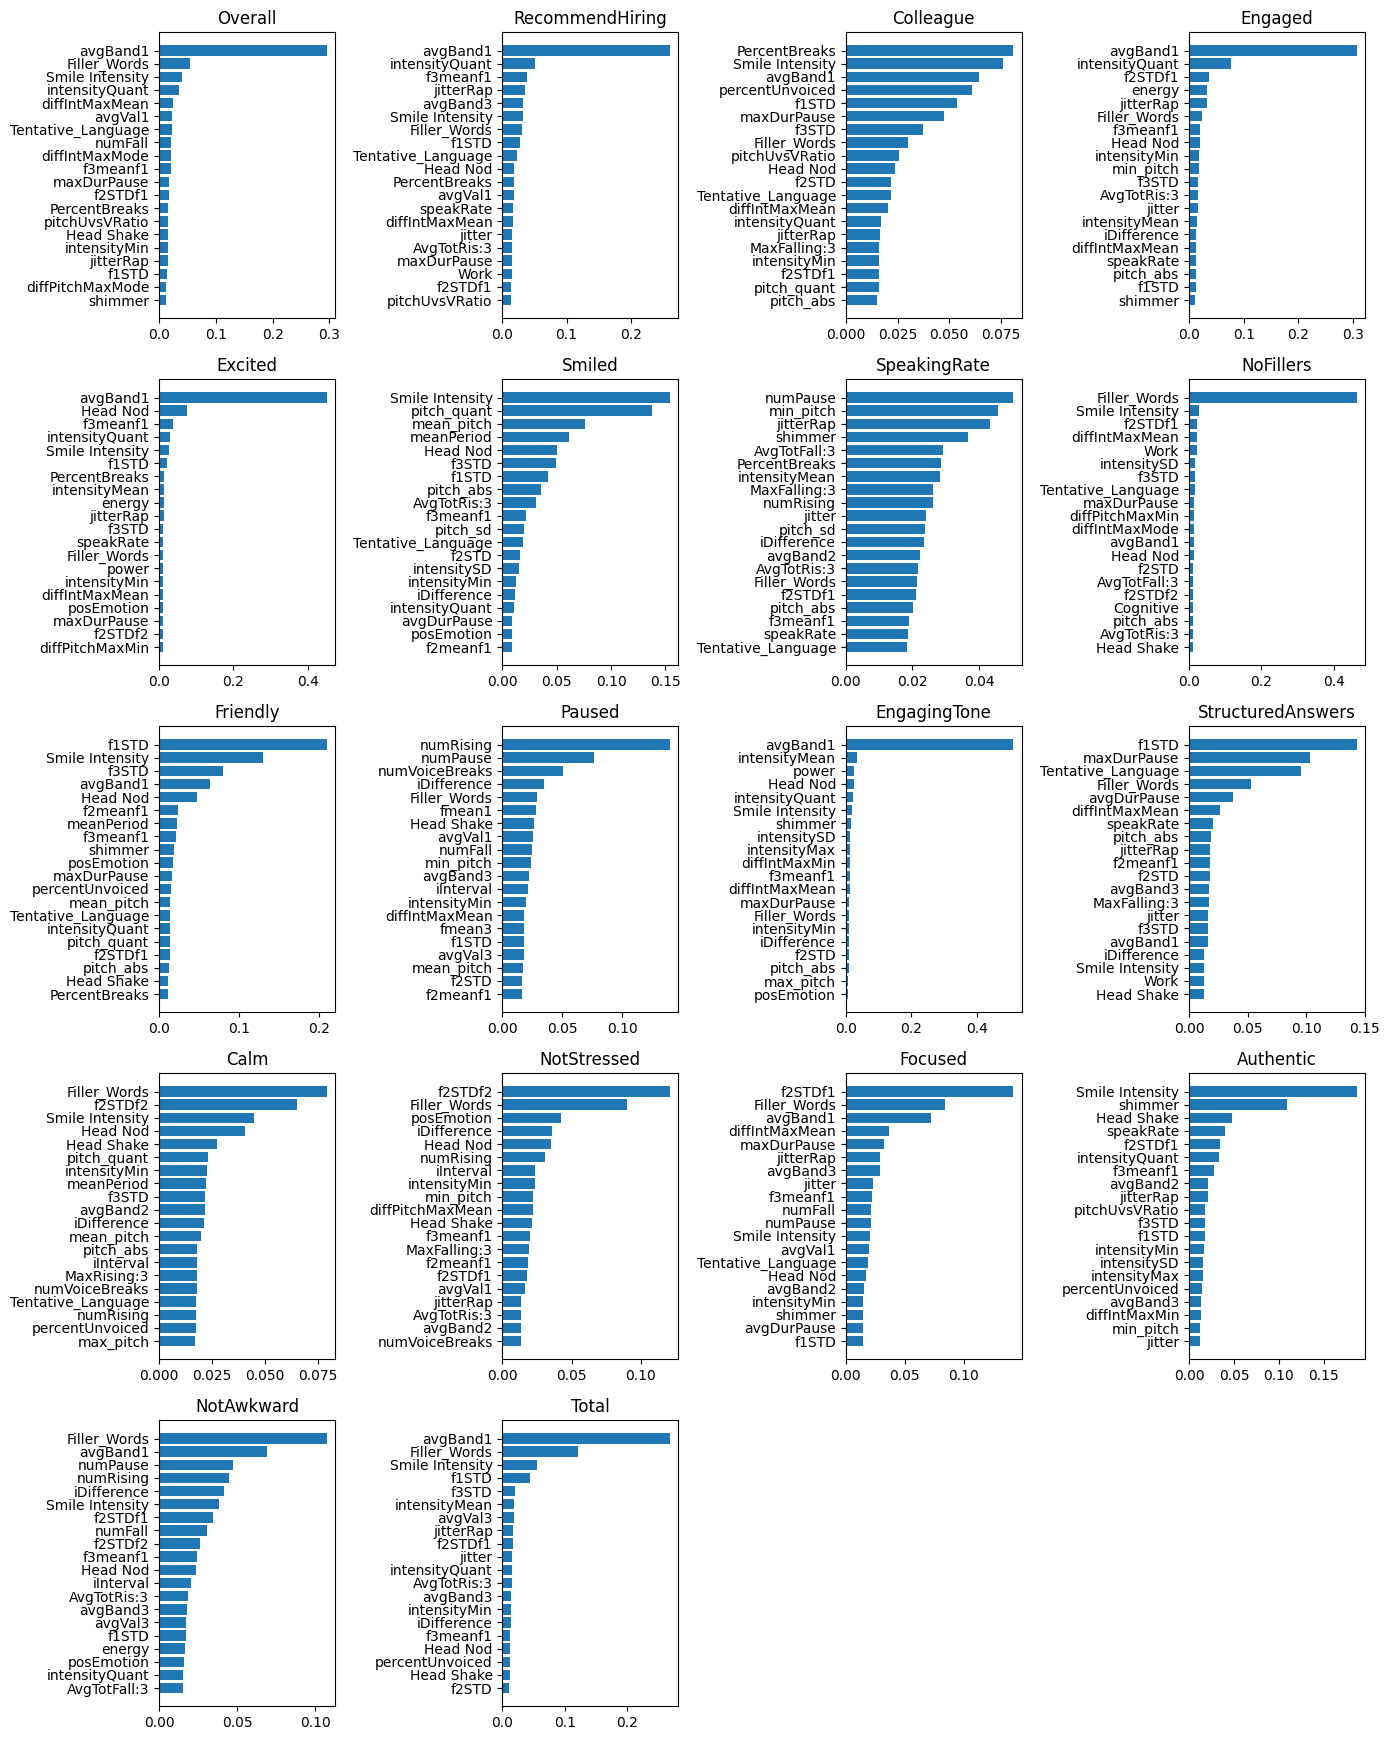

In [68]:
# Get feature importances for each target variable
importances = []
for estimator in multi_output_regressor.estimators_:
    importances.append(estimator.feature_importances_)

# Define the number of top features to display
top_features = 20

# Calculate the number of rows and columns for subplots
N = len(y.columns)
nrows = ceil(N / 4)
ncols = 4

# Create a grid of subplots based on the number of target variables
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5 * ncols, 3.5 * nrows))

# Iterate through target variables and create subplots
for i, (target, ax) in enumerate(zip(y.columns, axs.flat)):
    ax.set_title(target)
    
    # Get the feature importances for the i-th target
    target_importances = importances[i]
    indices = target_importances.argsort()[::-1]
    
    ax.barh(range(top_features), target_importances[indices][:top_features])
    ax.set_yticks(range(top_features))
    ax.set_yticklabels(X.columns[indices][:top_features])
    ax.invert_yaxis()

# Remove any remaining empty subplots
for i in range(N, nrows * ncols):
    fig.delaxes(axs.flat[i])

plt.tight_layout()
plt.show()


### Binary Classification


In [134]:
len(X_train)

110

In [147]:
labels = ['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'Smiled', 'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers', 'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']
medians = y_train.median()

y_pred_test = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred_train = multi_output_regressor.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=y_train.columns)

true_labels_binary_train = (y_train > medians).astype(int)
true_labels_binary_test = (y_test > medians).astype(int)
pred_labels_binary_train = (y_pred_train > medians).astype(int)
pred_labels_binary_test = (y_pred_test > medians).astype(int)


In [148]:
len(true_labels_binary_train)

110

In [150]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC AUC for both the training and testing data
roc_auc_train = roc_auc_score(true_labels_binary_train['Overall'], pred_labels_binary_train['Overall'])
roc_auc_test = roc_auc_score(true_labels_binary_test['Overall'], pred_labels_binary_test['Overall'])
roc_auc_train, roc_auc_test

# Plot the ROC curve
# fpr_train, tpr_train, _ = roc_curve(true_labels_binary_train, pred_labels_binary_train)
# fpr_test, tpr_test, _ = roc_curve(true_labels_binary_test, pred_labels_binary_test)



(0.8636363636363638, 0.5974358974358974)

Overall - Train ROC AUC: 0.8636, Test ROC AUC: 0.5974
RecommendHiring - Train ROC AUC: 0.9182, Test ROC AUC: 0.7897
Colleague - Train ROC AUC: 0.9000, Test ROC AUC: 0.7917
Engaged - Train ROC AUC: 0.9273, Test ROC AUC: 0.8369
Excited - Train ROC AUC: 0.9273, Test ROC AUC: 0.8944
Smiled - Train ROC AUC: 0.9364, Test ROC AUC: 0.7250
SpeakingRate - Train ROC AUC: 0.9273, Test ROC AUC: 0.5538
NoFillers - Train ROC AUC: 0.8818, Test ROC AUC: 0.7795
Friendly - Train ROC AUC: 0.9182, Test ROC AUC: 0.7914
Paused - Train ROC AUC: 0.9455, Test ROC AUC: 0.7143
EngagingTone - Train ROC AUC: 0.9455, Test ROC AUC: 0.8918
StructuredAnswers - Train ROC AUC: 0.9091, Test ROC AUC: 0.7833
Calm - Train ROC AUC: 0.9182, Test ROC AUC: 0.5714
NotStressed - Train ROC AUC: 0.9000, Test ROC AUC: 0.5556
Focused - Train ROC AUC: 0.9000, Test ROC AUC: 0.6979
Authentic - Train ROC AUC: 0.9091, Test ROC AUC: 0.6125
NotAwkward - Train ROC AUC: 0.9000, Test ROC AUC: 0.6000
Total - Train ROC AUC: 0.9273, Test ROC AUC: 

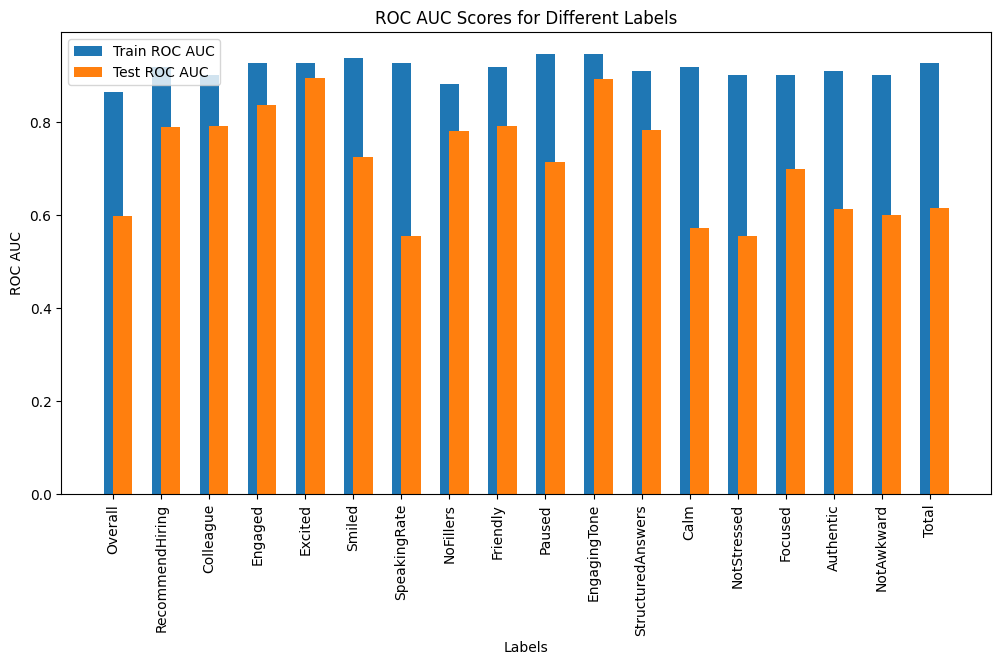

In [152]:
from sklearn.metrics import roc_auc_score

roc_auc_scores_train = []
roc_auc_scores_test = []

for label in labels:  # Iterate through your labels
    roc_auc_train = roc_auc_score(true_labels_binary_train[label], pred_labels_binary_train[label])
    roc_auc_test = roc_auc_score(true_labels_binary_test[label], pred_labels_binary_test[label])
    roc_auc_scores_train.append(roc_auc_train)
    roc_auc_scores_test.append(roc_auc_test)


plt.figure(figsize=(12, 6))
plt.bar(labels, roc_auc_scores_train, width=0.4, label='Train ROC AUC', align='center')
plt.bar(labels, roc_auc_scores_test, width=0.4, label='Test ROC AUC', align='edge')
plt.xlabel('Labels')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for Different Labels')
plt.xticks(rotation=90)
plt.legend()
plt.show()


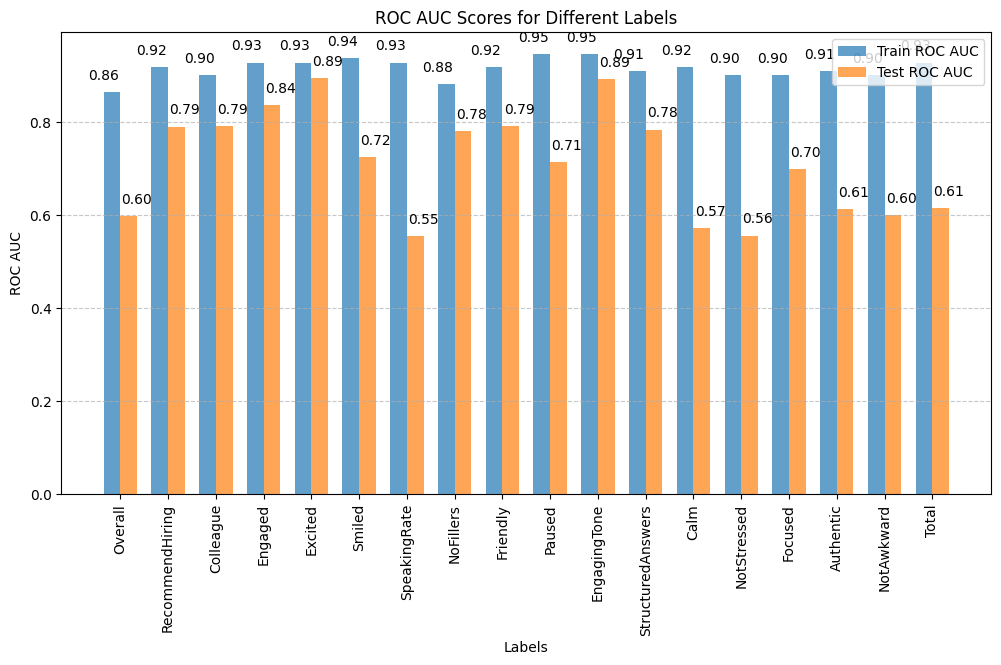

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have calculated roc_auc_scores_train and roc_auc_scores_test

# Set the figure size and create a new figure
plt.figure(figsize=(12, 6))

# Create an array for x-axis positions
x = np.arange(len(labels))

# Bar width
width = 0.35

# Plot the bars for train and test ROC AUC
plt.bar(x - width/2, roc_auc_scores_train, width, label='Train ROC AUC', alpha=0.7)
plt.bar(x + width/2, roc_auc_scores_test, width, label='Test ROC AUC', alpha=0.7)

# Beautify the graph
plt.xlabel('Labels')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Scores for Different Labels')
plt.xticks(x, labels, rotation=90)
plt.legend(loc='upper right')

# Add grid lines for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data values above the bars
for i in range(len(labels)):
    plt.text(x[i] - width, roc_auc_scores_train[i] + 0.02, f'{roc_auc_scores_train[i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + width, roc_auc_scores_test[i] + 0.02, f'{roc_auc_scores_test[i]:.2f}', ha='center', va='bottom')

plt.show()


In [155]:
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable

roc_auc_table = PrettyTable()
roc_auc_table.field_names = ["Label", "Train ROC AUC", "Test ROC AUC"]

roc_auc_data = []  # Create a list to store the data

for label in labels:  # Iterate through your labels
    roc_auc_train = roc_auc_score(true_labels_binary_train[label], pred_labels_binary_train[label])
    roc_auc_test = roc_auc_score(true_labels_binary_test[label], pred_labels_binary_test[label])
    roc_auc_data.append([label, roc_auc_train, roc_auc_test])

# Sort the data by the test ROC AUC values in descending order
roc_auc_data.sort(key=lambda x: x[2], reverse=True)

# Add the sorted data to the table
for row in roc_auc_data:
    roc_auc_table.add_row([row[0], f'{row[1]:.4f}', f'{row[2]:.4f}'])

print(roc_auc_table)


+-------------------+---------------+--------------+
|       Label       | Train ROC AUC | Test ROC AUC |
+-------------------+---------------+--------------+
|      Excited      |     0.9273    |    0.8944    |
|    EngagingTone   |     0.9455    |    0.8918    |
|      Engaged      |     0.9273    |    0.8369    |
|     Colleague     |     0.9000    |    0.7917    |
|      Friendly     |     0.9182    |    0.7914    |
|  RecommendHiring  |     0.9182    |    0.7897    |
| StructuredAnswers |     0.9091    |    0.7833    |
|     NoFillers     |     0.8818    |    0.7795    |
|       Smiled      |     0.9364    |    0.7250    |
|       Paused      |     0.9455    |    0.7143    |
|      Focused      |     0.9000    |    0.6979    |
|       Total       |     0.9273    |    0.6146    |
|     Authentic     |     0.9091    |    0.6125    |
|     NotAwkward    |     0.9000    |    0.6000    |
|      Overall      |     0.8636    |    0.5974    |
|        Calm       |     0.9182    |    0.571